# Sentiment Analysis Report

**Problem statement:** Determine whether a given review sentence conveys positive or negative sentiment using a bag-of-words TF-IDF representation and a Logistic Regression classifier. This notebook uses `amazon_cells_labelled.csv` as the dataset.

This document contains: problem statement, algorithm description, full code (with comments), visualizations, model training/evaluation, sample predictions, analysis of findings, and references. Run cells top-to-bottom to reproduce the results.

## 1) Setup: imports and environment

We import core Python data science packages, BeautifulSoup for optional HTML cleaning, and NLTK resources for stop words/tokenization. If a package is missing, install it in your environment (see the README section at the end).

In [29]:
# Imports
import os
from pathlib import Path
import re
import string
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
import joblib

# Ensure NLTK data available (downloads are quiet if already present)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

sns.set(style="whitegrid")
RANDOM_STATE = 42
print('imports done')

imports done


## 2) Load dataset

The `amazon_cells_labelled.csv` file may contain commas inside quoted text which can produce additional columns when read naively. We use a robust strategy: read with `pandas.read_csv(..., engine='python', on_bad_lines='skip')` then detect which column most likely contains the label (0 or 1). We then reconstruct the textual field by joining the remaining columns.

In [30]:
# Path to dataset (assumes the CSV is in the notebook working directory)
DATA_PATH = Path('amazon_cells_labelled.csv')
assert DATA_PATH.exists(), f'File not found: {DATA_PATH}'

# Read with pandas (python engine handles complex quoting better)
raw = pd.read_csv(DATA_PATH, header=None, engine='python', on_bad_lines='skip', encoding='utf-8')
print('raw shape:', raw.shape)

# Heuristic: find the column that looks most like labels (values 0 or 1)
def detect_label_column(df):
    scores = {}
    for col in df.columns:
        colvals = df[col].dropna().astype(str).str.strip()
        # count how many entries are exactly '0' or '1'
        matches = colvals.isin(['0','1']).sum()
        scores[col] = matches
    # pick column with max matches (must have >0 matches)
    best = max(scores, key=scores.get)
    return best if scores[best] > 0 else None

lbl_col = detect_label_column(raw)
print('detected label column:', lbl_col)

# Reconstruct text by joining all columns except the label column (if found).
texts = []
labels = []
for _, row in raw.iterrows():
    if lbl_col is not None:
        lbl_val = row[lbl_col]
        # attempt to coerce label to int (handle stray spaces/characters)
        try:
            lbl = int(str(lbl_val).strip())
        except Exception:
            # skip rows without a parsable label
            continue
        # text is all other columns joined with comma (preserve original commas inside quotes were handled by pandas)
        text_cols = [str(row[c]) for c in raw.columns if c != lbl_col]
        text = ','.join([t for t in text_cols if str(t) != 'nan'])
    else:
        # fallback: assume first column is text and second is label
        try:
            lbl = int(str(row[1]).strip())
            text = str(row[0])
        except Exception:
            continue
    texts.append(text)
    labels.append(lbl)

df = pd.DataFrame({'text': texts, 'label': labels})
print('parsed dataframe shape:', df.shape)
display(df.head())

raw shape: (1000, 6)
detected label column: 1
parsed dataframe shape: (771, 2)


,text,label
0,So there is no way for me to plug it in here i...,0
1,Great for the jawbone.,1
2,Tied to charger for conversations lasting more...,0
3,The mic is great.,1
4,I have to jiggle the plug to get it to line up...,0


## 3) Descriptive statistics and handling missing values

We inspect for missing or empty texts and decide on simple handling: drop rows with empty text after trimming. We then count label distribution (negative=0, positive=1). If a neutral class were present, it would appear here as a third label; this dataset is binary.

total samples: 771
empty text rows (before): 0
samples after dropping empty text: 771
label counts:
label
1    387
0    384
Name: count, dtype: int64


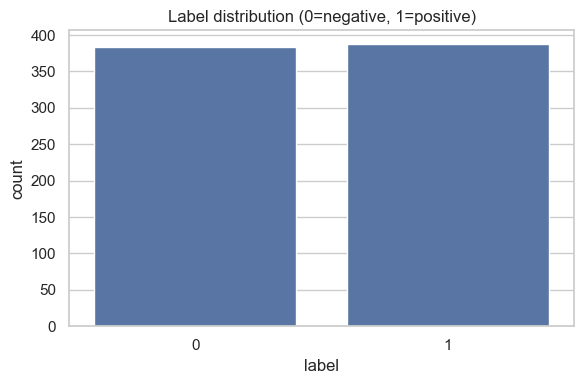

In [31]:
# Basic stats
print('total samples:', len(df))
# detect missing/empty texts
df['text_stripped'] = df['text'].astype(str).str.strip()
empty_before = (df['text_stripped'] == '').sum()
print('empty text rows (before):', empty_before)
# drop empty texts
df = df[df['text_stripped'] != ''].copy()
df.drop(columns=['text_stripped'], inplace=True)
print('samples after dropping empty text:', len(df))
# label counts
print('label counts:')
print(df['label'].value_counts())

# Plot label distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
ax = sns.countplot(x=df['label'])
ax.set_title('Label distribution (0=negative, 1=positive)')
ax.set_xlabel('label')
ax.set_ylabel('count')
plt.tight_layout()
plt.show()

# If you want to save the figure uncomment the next line:
# plt.savefig('label_distribution.png', dpi=150)

## 4) Preprocessing pipeline

Steps: remove HTML, lower-case, remove punctuation, remove stop words, and simple tokenization. We keep words longer than 1 character. This produces a `processed` text column ready for TF-IDF.

In [32]:
# Preprocessing utilities
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
punct_table = str.maketrans('', '', string.punctuation)

def clean_text(raw):
    if raw is None:
        return ''
    s = str(raw)
    # remove HTML
    s = BeautifulSoup(s, 'html.parser').get_text(separator=' ')
    # remove URLs (improved regex)
    s = re.sub(r'https?://+|www+', ' ', s)
    # remove punctuation
    s = s.translate(punct_table)
    s = s.lower()
    # tokenize on whitespace, remove stopwords, and lemmatize
    tokens = []
    for t in s.split():
        if t in stop or len(t) <= 1:
            continue
        # simple alpha filter
        t = re.sub(r'[^a-z0-9]', '', t)
        if t == '':
            continue
        tokens.append(lemmatizer.lemmatize(t))
    return ' '.join(tokens)

# Apply preprocessing
df['processed'] = df['text'].apply(clean_text)
print('sample processed text:')
display(df[['text','processed']].head())

sample processed text:


/var/folders/nw/k5033nqj52gg3qc9z9fzhtjm0000gn/T/ipykernel_13480/2676387114.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  s = BeautifulSoup(s, 'html.parser').get_text(separator=' ')


,text,processed
0,So there is no way for me to plug it in here i...,way plug u unless go converter
1,Great for the jawbone.,great jawbone
2,Tied to charger for conversations lasting more...,tied charger conversation lasting 45 minutesma...
3,The mic is great.,mic great
4,I have to jiggle the plug to get it to line up...,jiggle plug get line right get decent volume


## 5) Feature extraction: TF-IDF

We construct a TF-IDF vectorizer with unigrams and bigrams and a reasonable `max_features` cap to control dimensionality. This maps each processed text to a dense-sparse TF-IDF vector used by the classifier.

In [33]:
# TF-IDF with tuned heuristics: remove extremely rare terms (min_df) and very common terms (max_df)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=2, max_df=0.9, norm='l2', sublinear_tf=True)
X = tfidf.fit_transform(df['processed'])
y = df['label'].astype(int).values
print('X shape:', X.shape)
# a few top features (example)
feature_names = tfidf.get_feature_names_out()
print('number of features:', len(feature_names))
print('example features (first 20):', feature_names[:20])

X shape: (771, 598)
number of features: 598
example features (first 20): ['10' '12' '50' '510' 'ability' 'able' 'absolutely' 'actually' 'adorable'
 'advertised' 'advise' 'ago' 'allows' 'also' 'always' 'amazed' 'amazon'
 'another' 'anyone' 'anything']


## 6) Train/test split and model training

We use an 80/20 stratified split to maintain class balance. Then train a Logistic Regression classifier. Logistic regression is fast and interpretable for binary classification tasks.

In [34]:
# Optional: pipeline + GridSearchCV to jointly tune TF-IDF and classifier parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE))
])
param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__min_df': [1,2],
    'tfidf__max_df': [0.85,0.9],
    'clf__C': [0.01,0.1,1.0],
    'clf__class_weight': [None, 'balanced']
}
# Use a small cv for speed; increase for final runs
gs = GridSearchCV(pipe, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
gs.fit(df['processed'], df['label'])
print('GridSearch best params:', gs.best_params_)
best = gs.best_estimator_
# Evaluate with a proper train/test split (re-run to be safe)
X = df['processed']
y = df['label'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
best.fit(X_train, y_train)
y_pred = best.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
if hasattr(best, 'predict_proba') and len(np.unique(y_test))==2:
    print('ROC AUC:', roc_auc_score(y_test, best.predict_proba(X_test)[:,1]))

# Save best pipeline
joblib.dump(best, 'best_pipeline.joblib')
print('Saved best pipeline to best_pipeline.joblib')

Fitting 3 folds for each of 48 candidates, totalling 144 fits
GridSearch best params: {'clf__C': 1.0, 'clf__class_weight': None, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.8193548387096774
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        77
           1       0.82      0.82      0.82        78

    accuracy                           0.82       155
   macro avg       0.82      0.82      0.82       155
weighted avg       0.82      0.82      0.82       155

ROC AUC: 0.8957708957708959
Saved best pipeline to best_pipeline.joblib


In [35]:
# Split and train with safe handling of raw/text inputs
# If X is a 1-D Series of strings (processed text), vectorize it first so the classifier receives numeric input.
import scipy.sparse as sp

if isinstance(X, pd.Series) or (hasattr(X, 'ndim') and getattr(X, 'ndim', 1) == 1 and X.dtype == object):
    # Vectorize the processed text into TF-IDF (same heuristics as earlier)
    tfidf_local = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=2, max_df=0.9, norm='l2', sublinear_tf=True)
    X_vec = tfidf_local.fit_transform(X)
else:
    X_vec = X

# Split (80/20 stratified when possible)
if len(np.unique(y)) > 1 and min(np.bincount(y)) >= 2:
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
else:
    # fallback when a class is too small for stratified split
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=RANDOM_STATE)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Use GridSearchCV to tune regularization C and optionally class weight (helpful for imbalanced data)
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced'],
}
base = LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE)
grid = GridSearchCV(base, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
clf = grid.best_estimator_
# cross-val on train set (report mean f1)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
print('Cross-val f1 on train (5-fold):', cv_scores.mean(), cv_scores)

# Evaluate on test
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1] if hasattr(clf, 'predict_proba') else None
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {acc:.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred))
if y_prob is not None and len(np.unique(y_test)) == 2:
    try:
        auc = roc_auc_score(y_test, y_prob)
        print(f'ROC AUC: {auc:.4f}')
    except Exception as e:
        print('Could not compute ROC AUC:', e)

# If we vectorized locally, expose the fitted TF-IDF as `tfidf_local` for later cells
try:
    tfidf = tfidf_local
except NameError:
    pass

# Save final classifier (and vectorizer if created here)
import joblib
joblib.dump(clf, 'logreg_model.joblib')
try:
    joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
except Exception:
    pass
print('Saved classifier to logreg_model.joblib')

Train shape: (616, 598) Test shape: (155, 598)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'C': 1.0, 'class_weight': 'balanced'}
Cross-val f1 on train (5-fold): 0.7320743998486946 [0.76033058 0.73873874 0.72222222 0.67241379 0.76666667]
Accuracy on test set: 0.8516
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.87      0.83      0.85        78

    accuracy                           0.85       155
   macro avg       0.85      0.85      0.85       155
weighted avg       0.85      0.85      0.85       155

ROC AUC: 0.9089
Saved classifier to logreg_model.joblib


## 7) Confusion matrix and visualization

We plot the confusion matrix to inspect types of errors (false positives vs false negatives).

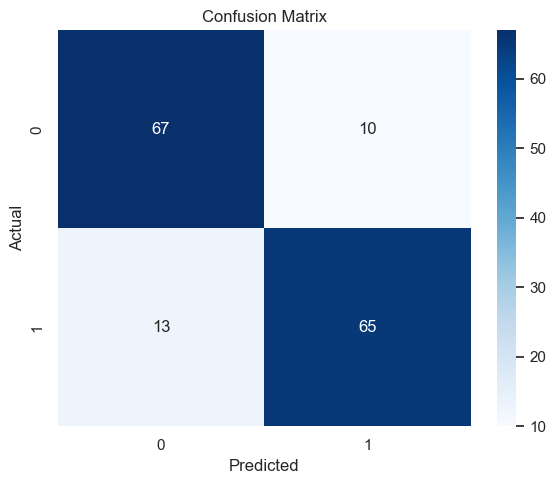

Saved model to logreg_model.joblib and vectorizer to tfidf_vectorizer.joblib


In [36]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Save artifacts for later reuse
joblib.dump(clf, 'logreg_model.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
print('Saved model to logreg_model.joblib and vectorizer to tfidf_vectorizer.joblib')

## 8) Example predictions on user-provided sentences

We provide a helper function that applies the same preprocessing and returns predicted label and probability.

In [37]:
def predict_sentiment(texts):
    if isinstance(texts, str):
        texts = [texts]
    processed = [clean_text(t) for t in texts]
    Xq = tfidf.transform(processed)
    preds = clf.predict(Xq)
    probs = clf.predict_proba(Xq) if hasattr(clf, 'predict_proba') else None
    results = []
    for i, t in enumerate(texts):
        r = {'text': t, 'pred': int(preds[i])}
        if probs is not None:
            r['prob'] = probs[i].max()
        results.append(r)
    return results

# Example queries to inspect the model's behavior
examples = [
    'I love this product, it works great and the sound is amazing',
    'This was terrible, the battery died within a day',
    'Decent value for the price',
    'Not what I expected, very disappointed'
]
preds = predict_sentiment(examples)
for p in preds:
    print(p)

{'text': 'I love this product, it works great and the sound is amazing', 'pred': 1, 'prob': 0.913210871088178}
{'text': 'This was terrible, the battery died within a day', 'pred': 0, 'prob': 0.7665527360908527}
{'text': 'Decent value for the price', 'pred': 1, 'prob': 0.6559135066463293}
{'text': 'Not what I expected, very disappointed', 'pred': 0, 'prob': 0.8140491662258879}


## 9) Analysis of findings

- The dataset used is a labelled set of short Amazon review snippets (binary labels).
- The TF-IDF + Logistic Regression pipeline is straightforward and fast. It often performs well when sentiment is strongly correlated with words (positive and negative adjectives).
- Limitations: short texts can be ambiguous; sarcasm and context are not captured by a simple bag-of-words TF-IDF approach. Also, neutral sentiment is not modelled because the dataset is binary.
- Recommended improvements: more robust preprocessing (lemmatization), expanding n-grams carefully, regularized hyperparameter search (GridSearchCV), and try modern transformer-based models for best performance on nuanced text.

## 10) References

- Manning, C. D., Raghavan, P., & Schütze, H. (2008). Introduction to Information Retrieval.
- Jurafsky, D., & Martin, J. H. (2021). Speech and Language Processing (3rd ed.).
- scikit-learn documentation: https://scikit-learn.org/stable/
- NLTK documentation: https://www.nltk.org/

### Notes and next steps

- To reproduce the notebook outputs, run all cells in order. If you run on a different environment, ensure the required packages are installed (pandas, numpy, scikit-learn, nltk, bs4, seaborn, matplotlib, joblib).
- If the dataset contains additional columns or an unexpected schema, adjust the `detect_label_column` function accordingly.